In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork(object):
    def __init__(self):
        #双层向前网络
        #定义层的大小
        self.inputLayerSize=2
        self.outputLayerSize=1
        self.hiddenLayerSize=3
        
        #定义权值Weights
        #3x2,2x3,3x1
        self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        
    #向前传播
    def forwardPropagation(self, X):
        #矩阵点乘
        self.z2 = np.dot(X, self.W1)
        #激励函数将输出非线性映射
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3)
        return yHat

    def sigmoid(self, z):
        #可以应用于标量，向量，矩阵
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self, z):
        #sigmoid梯度,导数
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        yHat = self.forwardPropagation(X)
        cost = 0.5*sum((y-yHat)**2)
        return cost
    
    def costFunctionPrime(self, X, y):
        #损失函数对于W1,W2的导数,逆向回馈时用到
        yHat = self.forwardPropagation(X)
#         print(len(X),len(X[0]))
#         print(len(y),len(y[0]))
        #总体损失对W1求偏导
        delta3 = (-(y-yHat))*self.sigmoidPrime(self.z3)
        dltW2 = np.dot(self.a2.T, delta3)

        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dltW1 = np.dot(X.T, delta2)
        
        return dltW1,dltW2
    
    #其它类交互函数，Checking Gradient
    def getParams(self):
        params = np.concatenate((self.W1.ravel(),self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #用单维向量params还原W1,W2
        W1_start = 0
        W1_end = self.inputLayerSize*self.hiddenLayerSize
        #print(params[W1_start:W1_end])
        self.W1 = np.reshape(params[W1_start:W1_end],(self.inputLayerSize,self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        #print(params[W1_end:W2_end])
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
    
    #计算逆向传播梯度
    def computeGradients(self, X, y):
        dltW1, dltW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dltW1.ravel(), dltW2.ravel()))

def computeGradientsCheck(NNet, X, y):
    params = NNet.getParams()
    #print(params)
    chkgrad = np.zeros(params.shape)
    perturb = np.zeros(params.shape)
    e = 1e-4
    
    for p in range(len(params)):
        perturb[p] = e
        NNet.setParams(params + perturb)
        loss2 = NNet.costFunction(X, y)
        
        NNet.setParams(params - perturb)
        loss1 = NNet.costFunction(X, y)
        
        chkgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
    
    #print(params)
    NNet.setParams(params)
    return chkgrad

[[0.3 1. ]
 [0.5 0.2]
 [1.  0.4]]
[[0.75]
 [0.82]
 [0.93]]
[[0.55583226]
 [0.54360071]
 [0.53722707]]


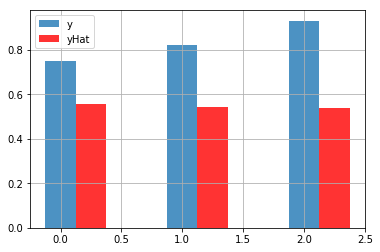

In [3]:
# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)

#规范化，取每列最大值，axis=1时取每行最大值
X = X/np.amax(X, axis = 0)
y = y/100

NN = NeuralNetwork()

yHat = NN.forwardPropagation(X)
print(X)
print(y)
print(yHat)

#比较yHat与y
plt.bar([0,1,2], y.reshape(3), width = 0.25, alpha=0.8)
plt.bar([0.25,1.25,2.25],yHat.reshape(3), width = 0.25, color='r', alpha=0.8)
plt.grid(1)
plt.legend(['y', 'yHat'])

In [4]:
cost1 = NN.costFunction(X,y)
dltW1, dltW2 = NN.costFunctionPrime(X,y)
print(dltW1)
print(dltW2)

[[ 0.02195316 -0.03033617 -0.00649795]
 [ 0.0137355  -0.0196172  -0.00454408]]
[[-0.15440027]
 [-0.12169655]
 [-0.17075437]]


In [5]:
learning_rate = 1

NN.W1 = NN.W1 - learning_rate*dltW1
NN.W2 = NN.W2 - learning_rate*dltW2
cost2 = NN.costFunction(X,y)

dltW1, dltW2 = NN.costFunctionPrime(X,y)
NN.W1 = NN.W1 - learning_rate*dltW1
NN.W2 = NN.W2 - learning_rate*dltW2
cost3 = NN.costFunction(X,y)

print(cost1,cost2,cost3)

[0.13418413] [0.07535919] [0.04744146]


In [6]:
from scipy import optimize

In [7]:
class Trainer(object):
    def __init__(self, NNet):
        self.NNet = NNet
    
    def callbackFunc(self, params):
        self.NNet.setParams(params)
        self.J.append(self.NNet.costFunction(self.X, self.y))
        
    def costFunctionWrapper(self, params, X, y):
        self.NNet.setParams(params)
        cost = self.NNet.costFunction(X, y)
        grad = self.NNet.computeGradients(X, y)
        
        return cost, grad
    
    def train(self, X, y):
        self.X = X
        self.y = y
        #列表存放每次向前传播损失
        self.J = []
        params0 = self.NNet.getParams()
        #print(params0)
        
        #用scipy中optimize优化,BFGS拟牛顿法,params不断迭代更新
        #最大迭代数maxiter,disp打印收敛信息
        options = {'maxiter':200, 'disp':True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, \
                                jac=True, method='BFGS',\
                                args=(X,y), options=options,\
                                callback=self.callbackFunc)
        self.NNet.setParams(_res.x)
        self.optimizationResults = _res

In [8]:
T = Trainer(NN)
T.train(X,y)
print(T.optimizationResults)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 59
         Gradient evaluations: 59
      fun: 5.059233212214826e-10
 hess_inv: array([[  9900.25582743, -19569.55441654,   -916.69252921,
          3574.17572617,  10528.64888502,   4130.85713312,
          3698.10723801,   9694.17536308, -14105.81555919],
       [-19569.55441654,  39117.77901298,   2067.69406365,
         -7042.65847276, -21046.57843279,  -8293.4982463 ,
         -7361.76328553, -19305.14942347,  28034.42386415],
       [  -916.69252921,   2067.69406365,    251.79194966,
          -317.828688  ,  -1113.87149584,   -446.62710476,
          -380.8080673 ,   -988.33958523,   1388.85431683],
       [  3574.17572617,  -7042.65847276,   -317.828688  ,
          1292.72560257,   3788.99094414,   1484.21957524,
          1332.82775077,   3492.89404771,  -5084.7335203 ],
       [ 10528.64888502, -21046.57843279,  -1113.87149584,
          378

Text(0,0.5,'Cost')

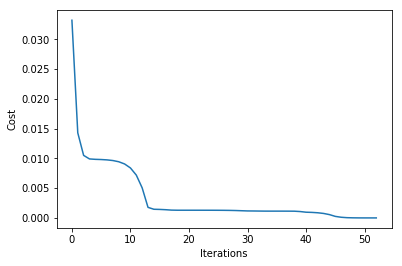

In [9]:
plt.plot(T.J)
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [23]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
#生成数据
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns = iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    #取前100行数据，第0、1、-1列
    data = np.array(df.iloc[:, [0, 1, -1]])
    return data[:,:2],data[:,-1]

X2, y2 = create_data()
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3)

#print(X_train)
# print(len(X_train),len(X_train[0]))
# print(y_train)
#规范化，取每列最大值，axis=1时取每行最大值
X_train = X_train/np.amax(X_train, axis = 0)
y_train = y_train/3

NN2 = NeuralNetwork()
T2 = Trainer(NN2)
T2.train(X_train,y_train.reshape(105,1))
print(T.optimizationResults)

Optimization terminated successfully.
         Current function value: 0.864432
         Iterations: 68
         Function evaluations: 76
         Gradient evaluations: 76
      fun: 0.7815753526549407
 hess_inv: array([[ 7.73248945e+02,  4.03715471e-02,  5.41895666e-13,
        -2.44986583e+02,  2.60867866e-02, -4.12465484e-05,
         3.53868281e+05,  2.74648204e+01, -9.45524701e-15],
       [ 4.03715471e-02,  1.00000246e+00,  8.92117129e-18,
        -8.85168781e-03,  1.58984485e-06, -2.51373765e-09,
         2.15662913e+01,  1.22437649e-03, -1.54835839e-19],
       [ 5.41895666e-13,  8.92117129e-18,  1.00000000e+00,
        -4.08378641e-13,  5.76453194e-18, -9.11539634e-21,
         7.81971840e-11,  2.56996216e-14,  0.00000000e+00],
       [-2.44986583e+02, -8.85168781e-03, -4.08378641e-13,
         1.24018681e+02, -5.71966520e-03,  9.04365639e-06,
        -7.75876528e+04, -1.03907721e+01,  7.13484125e-15],
       [ 2.60867866e-02,  1.58984485e-06,  5.76453194e-18,
        -5.71966

[[0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54612473]
 [0.54

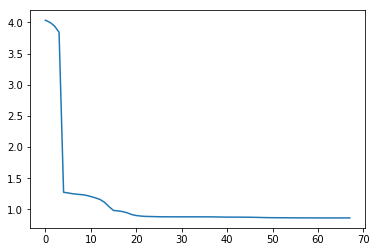

In [26]:
# X_test = X_train/np.amax(X_test, axis = 0)
print(NN2.forwardPropagation(X_test))
plt.plot(T2.J)